# Analysis of NSF Abstracts

Here we show some practical Text Analysis with emphasis on Feature Engineering on the collection of NSF Award abstracts. Abstracts are generously available at **UCI Machine Learning Dataset** collection by **Michael J. Pazzani** (hope my citation is right!).

Each document consists of a research abstract along with metadata including the name of NSF department to which the abstract belongs. Here is an example of how these documents look like:


<img src="doc_ex.png" width="800">

As seen above, the funded research is on Mathematics and the department is Devision of Mathematical Science with tag **DMS**.

For sake of practicing, we exclude all meta data and only use abstract text to predict the department.

In [1]:
# Imports
import pandas as pd
from IPython.display import display
import os
import itertools
import re
import numpy as np
import matplotlib.pyplot as plt 
import pickle 
import time
import string
from collections import Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
import warnings
from sklearn.decomposition import NMF, LatentDirichletAllocation
import nltk
from nltk.tokenize import RegexpTokenizer
warnings.simplefilter("ignore")

# Reading Raw Files

For sake of simplicity I used I processed data beforehand and here will just upload it but the process of reading files is in the **read_data** function for those who want to check.

In this showcase we use data only from **1995** to **2003**. The complete dataset is from 1990 to 2003 with almost 129000 documents. 

**PS:** *Later I decided to limit the scope of analysis to only 3 tags (classes) to ease running the notebook for everyone. You may skip this limitation and explore a broader analysis.*

In [2]:
def read_data(nsf_data_dir, pfile=False, wrt=False):
    if pfile == True:
        data = pickle.load( open( "data_1995_2003.p", "rb" ) )
        return data
    d = {}

    for root, dirs, files in os.walk(nsf_data_dir):
        print(root)
        for f in files:
            if 'txt' in f:
                d[f] = []
                fle = open(os.path.join(root, f), "r")
                content = ' '.join([ii.strip() for ii in fle.readlines()])
                d[f].append(re.search(r'NSF Org(.*?)Latest', content).group(1).strip(': '))
                d[f].append(content.split('Abstract')[1].strip(':  '))
                fle.close()

    
    data = pd.DataFrame.from_dict(d, orient='index')
    data.columns = ['Tag','Text']
    data['Text'] = data['Text'].str.replace('\n',' ').str.lower() # Removing new lines / Upper-Case to Lower-Case
    data['Text'] = data['Text'].str.replace('\t',' ') # Removing tabs
    data['Text'] = data['Text'].str.replace('_',' ') 
    data['Text'] = data['Text'].str.replace('[^\w\s]',' ') # Removing punctuations
    data['Text'] = data['Text'].apply(lambda x: x.translate(str.maketrans(' ',' ',string.digits))) # Removing numbers
    if wrt:
        pickle.dump( data, open( "data_1995_2003.p", "wb" ) )
    
    return data

Indices are the file names and two columns Text and Tag represent the research abstract and the department respectively. As you see bellow a part of abstracts are not available! The description of data shows even more duplicate texts.

Let's go through them:

In [11]:
# I initially choose only 3 tags to ease and lighten the whole tutorial. 
# You can start (and even finish!) with larger fraction of data.
data = read_data('NSF',pfile=True)
data = data[data['Tag'].isin(['OCE','DMS','CHE'])]

# Have a look at how data is organized
display(data.head())

# Get a summary of data
display(data.describe())

,Tag,Text
a9500010.txt,DMS,goncharov professor goncharov will work ...
a9500016.txt,DMS,this award supports research on the representa...
a9500062.txt,DMS,re dms conference on multiple decision t...
a9500125.txt,DMS,kalton the principal investigator plans to ...
a9500235.txt,DMS,dms de souza brown this award will contin...


,Tag,Text
count,13358,13358
unique,3,11326
top,DMS,
freq,6219,700


In [12]:
# Search duplicates and keep only one from each
for text,count in Counter(data['Text']).items():
    if count>1:
        data.drop(list(data.index[data['Text']==text])[1::],axis=0,inplace=True)

# Get a summary of data again
display(data.describe())

,Tag,Text
count,11326,11326
unique,3,11326
top,DMS,stroock abstract the principal investigato...
freq,4893,1


So the problem of duplicates is solved (in a blind way!) but is every abstract informative?

Let's explore short abstracts:

In [13]:
# Search short (probably not informative) abstracts
c = Counter(data['Text'])
for text, count in c.items():
    if len(text) < 150: # try with 1000 as well and see how it affects
        data.drop(data.index[data['Text']==text],axis=0,inplace=True)
        
# Get a summary of data again
display(data.describe())

,Tag,Text
count,10953,10953
unique,3,10953
top,DMS,stroock abstract the principal investigato...
freq,4542,1


Before starting anything, we need to know how classes (here *Tags*) are distributed as a general aspect of data. Histograms are the right way to do this but here I would like to show more detailed information so I simply sort the class populations and plot it.

**PS:** *It makes much more sense in the presence of whole dataset. Now we are limited to only 3 classes. Please remove this limitation and run the code again to get a better insight about what imbalance class distribution means.*

In [26]:
# print('Class population in ascending order:\n',sorted(list(Counter(data['Tag'].tolist()).values())))
# plt.figure(figsize=(15,5))
# plt.plot(sorted(list(Counter(data['Tag'].tolist()).values())),'-*')
# plt.ylabel('Population of Classes')
# plt.xlabel('Class Index')
# plt.show()

### Now we can also check the histogram but we choose bins to put close class populations together.

print('Class populations\n',Counter(data['Tag'].tolist()).items())#('First 20 largest classes:\n',Counter(data['Tag'].tolist()).most_common(20))
# plt.figure(figsize=(15,5))
# plt.hist(list(Counter(data['Tag'].tolist()).values()),bins=40)
# plt.ylabel('# of Classes')
# plt.xlabel('Class Population')
# plt.show()

Class populations
 dict_items([('DMS', 4542), ('CHE', 3348), ('OCE', 3063)])


Let's reduce problem to some classes with almost similar number of samples according to the histogram above (**1000** to **2000**)

**PS:** *This does not make sense on the reduced version of problem. Try it on the whole dataset.*

In [31]:
tags = ['OCE','DMS','CHE'] 
# We already chose these tags at the beginning. It was supposed to happen here. 
# Since now on the original task equals the reduced version.

# To start our journey, we first need to tokenize the data
data = data[data.Tag.isin(tags)]
data['Tokens'] = data.apply(lambda row: nltk.word_tokenize(row['Text'].strip()), axis=1)
print(len(data),'samples from',len(tags),'classes')

10953 samples from 3 classes


Let's check the abstract length (in words and characters) as well. It is a pretty naive feature but let's explore it:

minimum text length (in char) is: 150
maximum text length (in char) is: 7941
mean and median text lengths (in char) are: 1560.3764265498037 1398.0


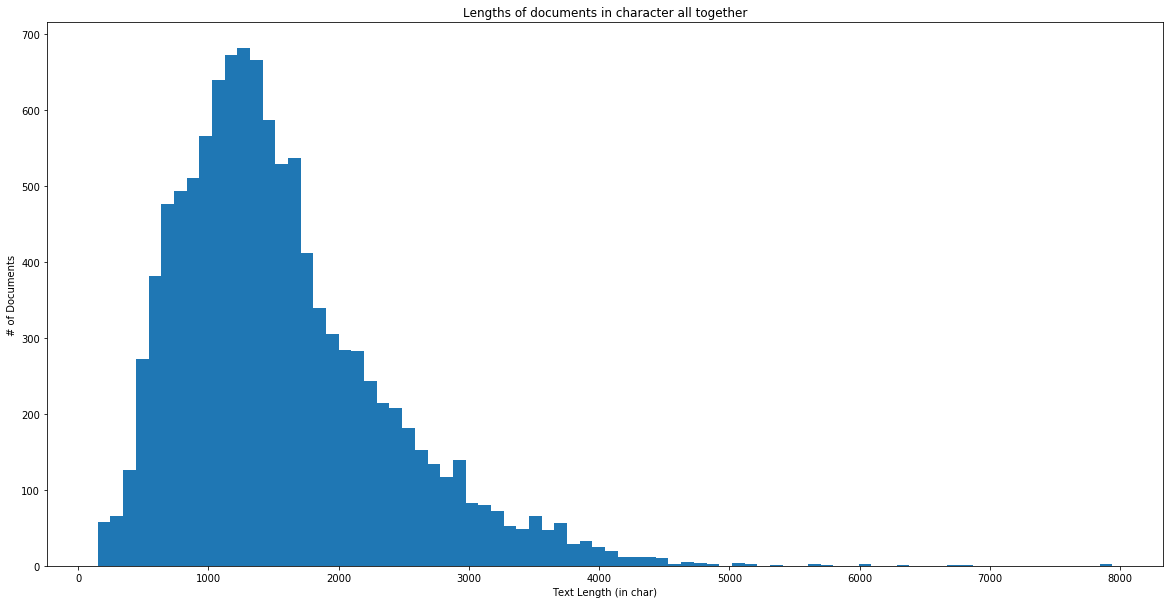

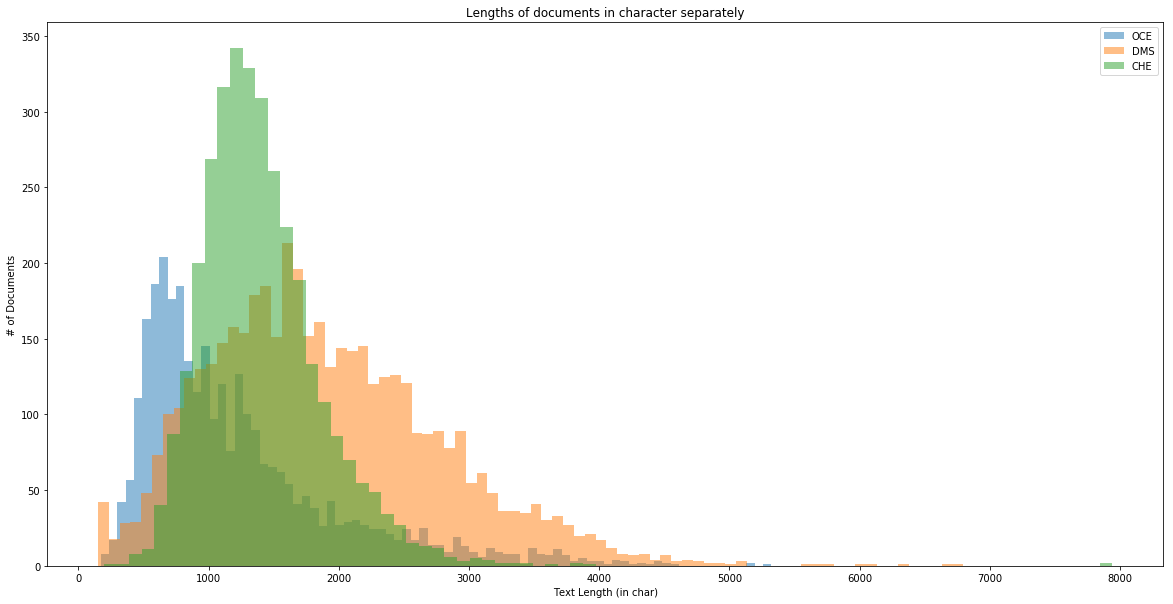

minimum text length (in token) is: 14
maximum text length (in token) is: 985
mean and median text lengths (in token) are: 228.57682826622843 202.0


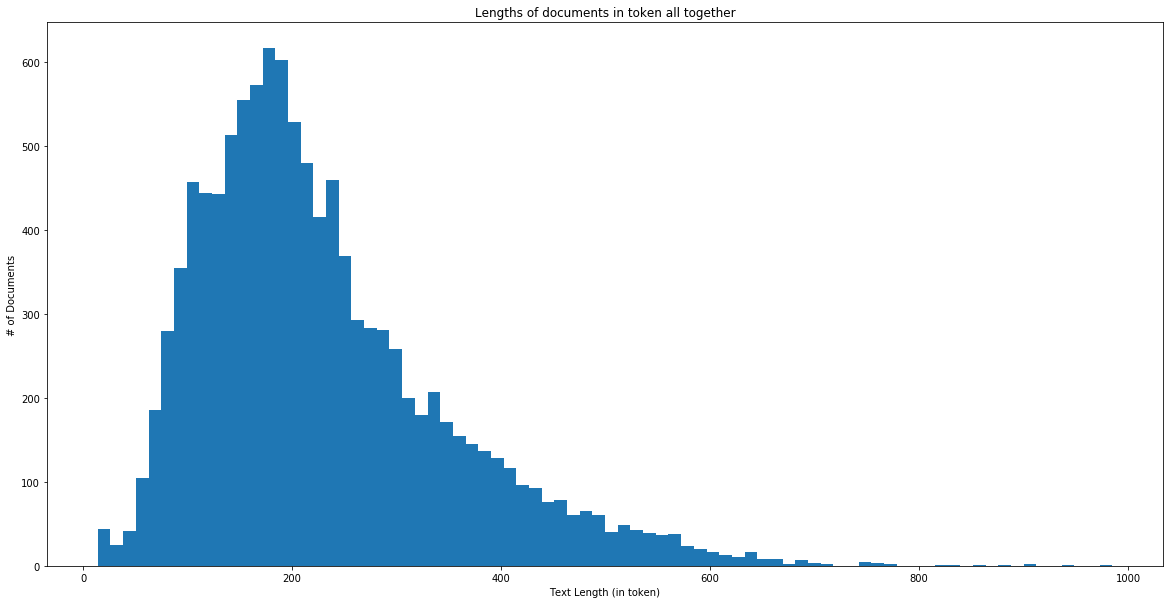

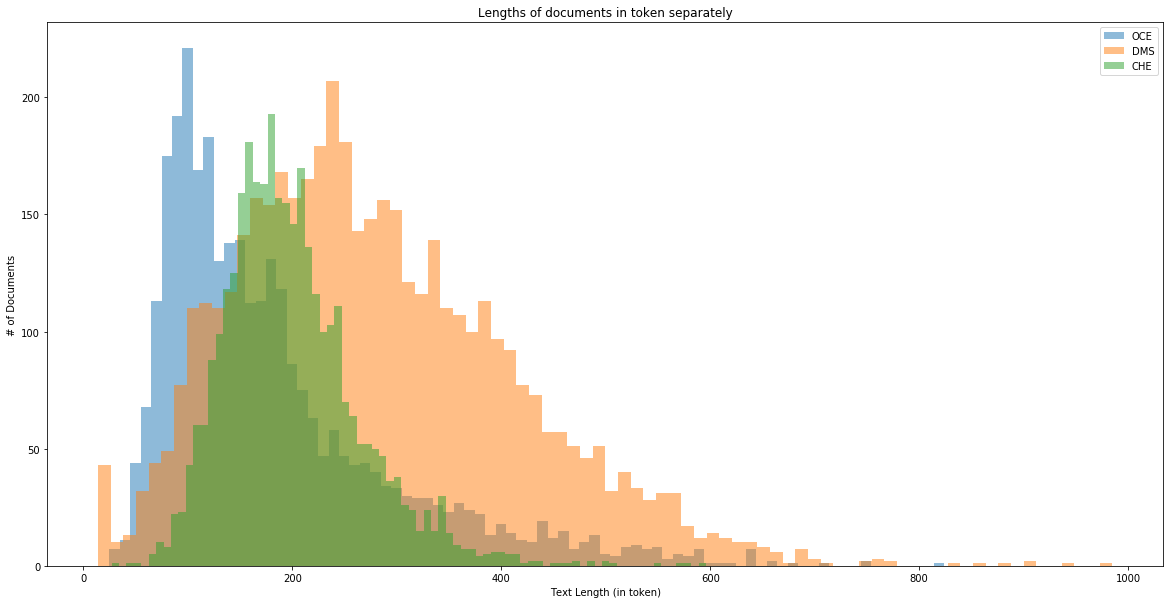

In [41]:
# Lengths of documents in character all together
lens = [len(ii) for ii in data.Text]
print('minimum text length (in char) is:',np.min(lens))
print('maximum text length (in char) is:',np.max(lens))
print('mean and median text lengths (in char) are:',np.mean(lens),np.median(lens))
plt.figure(figsize=(20,10))
plt.hist(lens,bins=80)
plt.xlabel('Text Length (in char)')
plt.ylabel('# of Documents')
plt.title('Lengths of documents in character all together')
plt.show()

# Lengths of documents in character separately
lens = {tag:[len(ii) for ii in data.loc[data['Tag']==tag].Text] for tag in tags}
plt.figure(figsize=(20,10))
for tag in tags:
    plt.hist(lens[tag],bins=80,alpha=.5,label=tag)
    plt.xlabel('Text Length (in char)')
    plt.ylabel('# of Documents')
    plt.title('Lengths of documents in character separately')
plt.legend()
plt.show()

# Lengths of documents in token all together
lens = [len(ii) for ii in data.Tokens]
print('minimum text length (in token) is:',np.min(lens))
print('maximum text length (in token) is:',np.max(lens))
print('mean and median text lengths (in token) are:',np.mean(lens),np.median(lens))
plt.figure(figsize=(20,10))
plt.hist(lens,bins=80)
plt.xlabel('Text Length (in token)')
plt.ylabel('# of Documents')
plt.title('Lengths of documents in token all together')
plt.show()

# Lengths of documents in token separately
lens = {tag:[len(ii) for ii in data.loc[data['Tag']==tag].Tokens] for tag in tags}
plt.figure(figsize=(20,10))
for tag in tags:
    plt.hist(lens[tag],bins=80,alpha=.5,label=tag)
    plt.xlabel('Text Length (in token)')
    plt.ylabel('# of Documents')
    plt.title('Lengths of documents in token separately')
plt.legend()
plt.show()

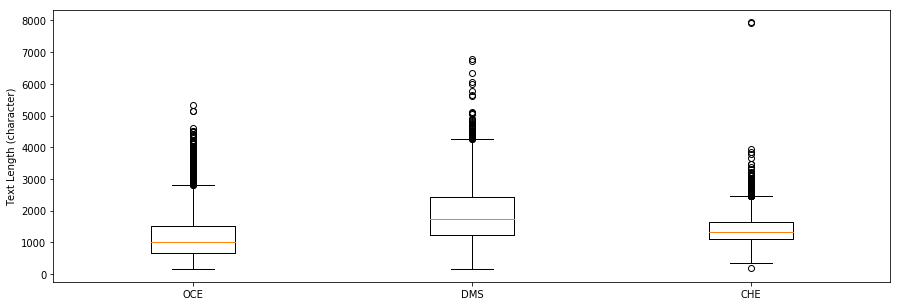

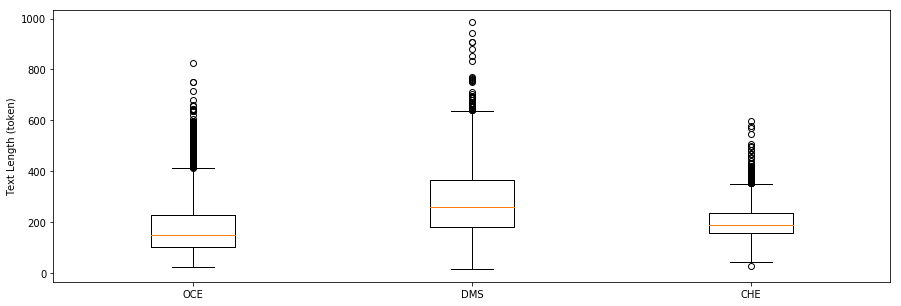

In [43]:
def len_of_tag_char(tag):
    return [len(ii) for ii in data[data.Tag == tag]['Text']]
def len_of_tag_tok(tag):
    return [len(ii) for ii in data[data.Tag == tag]['Tokens']]

lengths = [len_of_tag_char(tag) for tag in tags]
plt.figure(figsize=(15,5))
plt.boxplot(lengths)
plt.ylabel('Text Length (character)')
plt.xticks([ii for ii in range(1,len(tags)+1)], tags)
plt.show()


lengths = [len_of_tag_tok(tag) for tag in tags]
plt.figure(figsize=(15,5))
plt.boxplot(lengths)
plt.ylabel('Text Length (token)')
plt.xticks([ii for ii in range(1,len(tags)+1)], tags)
plt.show()


Let's continue with finding StopWords and important words. StopWords are non-informative words inside the corpus.

In [47]:
c_total = Counter()
for ind in data.index:
    c_total.update(Counter(data.loc[ind].Tokens))

In this container, we saved the number of occurances of **each word** in **all documents**. Let's have a look at it:

In [48]:
print(c_total.most_common(50))

[('the', 167841), ('of', 136646), ('and', 95435), ('to', 62438), ('in', 62062), ('a', 44013), ('will', 32063), ('is', 29805), ('for', 27672), ('this', 24233), ('be', 22411), ('on', 18623), ('with', 16997), ('are', 16749), ('research', 16406), ('as', 15970), ('that', 15451), ('by', 14228), ('these', 11144), ('from', 10978), ('at', 9827), ('which', 9180), ('an', 9054), ('theory', 8496), ('chemistry', 8401), ('project', 8390), ('study', 8011), ('such', 7235), ('new', 7114), ('program', 6768), ('problems', 6428), ('have', 6299), ('systems', 6198), ('or', 6039), ('university', 5615), ('it', 5600), ('can', 5454), ('methods', 5424), ('has', 5391), ('work', 5239), ('one', 5159), ('data', 4954), ('their', 4953), ('used', 4789), ('models', 4756), ('s', 4669), ('mathematical', 4555), ('also', 4522), ('studies', 4475), ('important', 4266)]


Now we check the number of times each word appeared in **different documents (Document Frequency)** i.e. if a word appeard several times within a document, we count only one.

This reveals a part of our **curpos-based StopWord** list:

In [49]:
c_unique = Counter()
for ind in data.index:
    c_unique.update(Counter(set(data.loc[ind].Tokens)))

Let's have a look at them. Are they really StopWords??!!!

In [55]:
print('First 15 common words:\n')
for word in c_unique.most_common(15):
    print(word[0],'-->', 'appeared in',word[1],'documents out of 10953 documents i.e.',np.round(100*word[1]/len(data),2),'%')

First 15 common words:

of --> appeared in 10910 documents out of 10953 documents i.e. 99.61 %
the --> appeared in 10899 documents out of 10953 documents i.e. 99.51 %
and --> appeared in 10878 documents out of 10953 documents i.e. 99.32 %
to --> appeared in 10597 documents out of 10953 documents i.e. 96.75 %
in --> appeared in 10572 documents out of 10953 documents i.e. 96.52 %
a --> appeared in 9989 documents out of 10953 documents i.e. 91.2 %
this --> appeared in 9429 documents out of 10953 documents i.e. 86.09 %
for --> appeared in 9058 documents out of 10953 documents i.e. 82.7 %
is --> appeared in 9030 documents out of 10953 documents i.e. 82.44 %
will --> appeared in 8979 documents out of 10953 documents i.e. 81.98 %
be --> appeared in 8227 documents out of 10953 documents i.e. 75.11 %
on --> appeared in 7954 documents out of 10953 documents i.e. 72.62 %
with --> appeared in 7758 documents out of 10953 documents i.e. 70.83 %
by --> appeared in 7063 documents out of 10953 document

and what about the total number of words?

In [64]:
print('There are',len(c_unique),'unique words i.e. the complete size of our vocab.\
 This is the intrinsic dimension of any BoW representation.')

print(np.sum(list(c_total.values())), 'words in total (with repeatations) i.e. sum of BoW matrix elements.')

There are 40609 unique words i.e. the complete size of our vocab. This is the intrinsic dimension of any BoW representation.
2503602 words in total (with repeatations) i.e. sum of BoW matrix elements.


Let's check the class-based specification of each word:

In [65]:
tag_dict = {tag:Counter() for tag in data.Tag.unique()}
for ind in data.index:
    tag = data.loc[ind]['Tag']
    tag_dict[tag].update(Counter(set(data.loc[ind].Tokens)))

Now a fun starts with a basic example. Let's see how words are assigned to tags and what we can infer from this.

In [67]:
tag_specific_words = pd.DataFrame(columns=['OCE_Words','OCE_%','CHE_Words','CHE_%','DMS_Words','DMS_%'])
for tag in ['OCE','CHE', 'DMS']:
    len_tag = len(data[data['Tag']==tag])
    words = []
    percent = []
    for word in tag_dict[tag].most_common(15):
        words.append(word[0])
        percent.append(np.round(100*word[1]/len_tag,2))
    tag_specific_words[tag+'_Words'] = words
    tag_specific_words[tag+'_%'] = percent
display(tag_specific_words)

,OCE_Words,OCE_%,CHE_Words,CHE_%,DMS_Words,DMS_%
0,the,99.87,the,99.97,of,99.49
1,of,99.41,of,99.94,and,99.14
2,and,99.12,and,99.73,the,98.92
3,to,96.47,in,97.01,in,98.28
4,will,93.37,chemistry,96.74,to,96.96
5,in,93.37,to,96.71,a,93.77
6,a,88.18,will,92.03,is,89.56
7,this,82.53,program,91.97,for,88.51
8,be,74.31,a,90.47,this,86.35
9,for,73.39,this,88.98,on,80.23


Now I repeat the same but this time let's remove some of the very frequent StopWords. It means that we are going from least specific word-tag relation to most specific one. Recall the concept of underfitting-overfitting. (Please note that we did not find all StopWords yet)

So let's go this way; first we find most frequent words of each tag ignoring first 50 most common words we found. Then we do it with ignoring first 500 common words and then 5000 and see the results. 

In [69]:
for n_stop_words in [50,500,5000]:
    tag_specific_words = pd.DataFrame(columns=['OCE_Words','OCE_%','CHE_Words','CHE_%','DMS_Words','DMS_%'])
    print('Ignoring first',n_stop_words,'stop-words ##############')
    StopWords = [ii[0] for ii in c_unique.most_common(n_stop_words)]
    for tag in ['OCE','CHE', 'DMS']:
        len_tag = len(data[data['Tag']==tag])
        jj = 0
        words = []
        percent = []
        for word in tag_dict[tag].most_common(2*n_stop_words):
            if word[0] not in StopWords:
                words.append(word[0])
                percent.append(np.round(100*word[1]/len_tag,2))
                jj += 1
            if jj == 20:
                break
        tag_specific_words[tag+'_Words'] = words
        tag_specific_words[tag+'_%'] = percent
    display(tag_specific_words)
    print('\n\n')

Ignoring first 50 stop-words ##############


,OCE_Words,OCE_%,CHE_Words,CHE_%,DMS_Words,DMS_%
0,ocean,48.29,award,48.60,mathematical,49.34
1,data,37.64,department,46.12,applications,40.95
2,provide,28.66,organic,40.83,mathematics,38.99
3,marine,28.21,chemical,40.17,many,37.30
4,water,25.43,molecules,39.37,analysis,36.46
5,use,25.11,supported,38.80,two,34.54
6,during,22.89,professor,37.13,more,33.25
7,processes,22.66,reactions,34.53,equations,33.00
8,system,22.33,state,34.53,areas,30.74
9,support,21.91,molecular,34.23,not,30.63





Ignoring first 500 stop-words ##############


,OCE_Words,OCE_%,CHE_Words,CHE_%,DMS_Words,DMS_%
0,pacific,14.01,bioinorganic,13.89,equation,9.47
1,circulation,13.29,atoms,12.63,connections,9.40
2,atlantic,13.12,reactivity,12.51,mathematicians,9.38
3,operated,12.01,facilities,11.77,computation,9.25
4,variability,11.46,molecule,11.56,conjecture,8.98
5,oceanic,11.43,catalysts,11.44,existence,8.81
6,samples,11.03,resonance,11.41,random,8.78
7,oce,10.87,polymers,11.35,subject,8.65
8,vessel,10.81,containing,11.20,representation,8.48
9,coastal,10.74,catalysis,11.08,discrete,8.32





Ignoring first 5000 stop-words ##############


,OCE_Words,OCE_%,CHE_Words,CHE_%,DMS_Words,DMS_%
0,rov,0.91,heme,0.84,lecturer,0.62
1,sargasso,0.91,tin,0.81,grothendieck,0.62
2,downwelling,0.91,optoelectronic,0.81,walk,0.62
3,intertidal,0.88,amine,0.81,connes,0.59
4,irradiance,0.88,biomimetic,0.78,nilpotent,0.59
5,expedition,0.88,rhodium,0.78,lifting,0.59
6,multibeam,0.85,aldehydes,0.78,obstructions,0.59
7,borehole,0.85,bimetallic,0.78,markets,0.59
8,iceland,0.85,alkynes,0.78,bootstrap,0.59
9,diapycnal,0.85,antibiotics,0.78,estimator,0.59


Interesting ...! We are clearly seeing what *Feature* means in terms of *Text Data*.

Let's go on by doing the same but this time with calculating some information theoretic score for each word to be selected as a feature (feature importance, ranking, selection, blahblah). Later we can compare the performance of our methods on these words with the performance of the same models on other feature sets like BoW variations.

The score is calculated based on the intuitive idea bellow

### How class-informative is a word? i.e. how confident you can predict the class of a text if you see this word in it?

To do this we calculate an information-theoretic inspired score as follows:

$$\large S(w_{i}) = \frac{1}{N_{c}-1}\times\frac{N_{c}-N_{w_{i},c}}{N_{w_{i},c}} $$

where $N_{w,c}$ is the number of classes in which the word $w_{i}$ appeard, and $N_{c}$ is the total number of classes. This score is bounded between $0$ and $1$ (I confess that I complicated a simple concept too much but it became beatiful at least :P ).

## Advantage
* Captures the most distingushable words.
* Does not need normalization by class sizes as it looks at word appearence in a binary way.

## Disadvantage
* Pretty naive idea! Of course the total number of appearences in classes is more informative than *if the word $w$ ever appeared in class $c$ or not*.
 * Just assume the case that a word appears in $N_{c}-1$ classes only once and in one class $10k$ times.
 
 
* Danger zone! The features captured here are pretty special such that do not capture an unseen document in general (overfitting problem).
 * **Solution**: randomly add not-so-special words to this dictionary to improve generalization (doesn't looks like Regularization?!).
* It **CAN NOT** consider all classes i.e. the score **DOES NOT** tell to which class a word belongs!
 * A slight modification on the formulation can solve this problem. In this case we calculate the top $n$ best words for each class and concatenate them to construct feature vector **(It will become a supervised version of what we know as TF-IDF :) )**

In [70]:
import itertools
tags = data.Tag.unique().tolist()
vocabs = {}
for tag in tags:
    data_tmp = data[data.Tag==tag]
    tmp = [data_tmp.loc[ind].Tokens for ind in data_tmp.index]
    vocabs[tag] = set(list(itertools.chain.from_iterable(tmp)))
    print(len(data[data.Tag==tag]),'documents and',len(vocabs[tag]),'unique terms in class',tag)


4542 documents and 23720 unique terms in class DMS
3348 documents and 19114 unique terms in class CHE
3063 documents and 16856 unique terms in class OCE


In [71]:

word_scores = {}
for word in c_unique.keys():
    N_wc=len([tag for tag in tags if word in vocabs[tag]])
    word_scores[word] = (1./2.)*(3.-N_wc)/N_wc

import operator
sorted_word_scores = sorted(word_scores.items(), key=operator.itemgetter(1))
print('Some low-score examples:\n')
print(sorted_word_scores[0:100],'\n')
print('Some high-score examples:\n')
print(sorted_word_scores[-100::])

Counter(list(word_scores.values()))

Some low-score examples:

[('explore', 0.0), ('new', 0.0), ('an', 0.0), ('essential', 0.0), ('l', 0.0), ('work', 0.0), ('recently', 0.0), ('many', 0.0), ('special', 0.0), ('theories', 0.0), ('is', 0.0), ('codes', 0.0), ('such', 0.0), ('subject', 0.0), ('will', 0.0), ('into', 0.0), ('computation', 0.0), ('having', 0.0), ('are', 0.0), ('on', 0.0), ('goal', 0.0), ('a', 0.0), ('and', 0.0), ('of', 0.0), ('mathematics', 0.0), ('among', 0.0), ('the', 0.0), ('connections', 0.0), ('geometry', 0.0), ('classical', 0.0), ('k', 0.0), ('regulator', 0.0), ('falls', 0.0), ('problems', 0.0), ('also', 0.0), ('compact', 0.0), ('he', 0.0), ('area', 0.0), ('proved', 0.0), ('relationship', 0.0), ('its', 0.0), ('two', 0.0), ('between', 0.0), ('explicit', 0.0), ('that', 0.0), ('generations', 0.0), ('combination', 0.0), ('theory', 0.0), ('correcting', 0.0), ('has', 0.0), ('both', 0.0), ('general', 0.0), ('groups', 0.0), ('this', 0.0), ('extraordinarily', 0.0), ('functions', 0.0), ('computers', 0.0), ('project'

Counter({0.0: 6552, 0.25: 5977, 1.0: 28080})

### Some take-home messages!

 1. The term *geometry* is probably much more related to mathematics rather than chemistry or ocean science. But the score is zero because we counted **if this ever appeared in the class**, thus only one appearence in CHE and OCE classes (which is not that unlikely) will kill the score! Just to tell you how naive our features are now and show you an interesting classification results even with such naive approach.
 
 2. Item (1) shows that if we count **how many times a word appear in each class** we will probably improve our results. We will see later
 
 3. There is the word *studens* in high-score words just because it was misspelled! Welcome to the world of texts!

You can check one of predifined StopWord lists (e.g. Gensim, NLTK, etc.) and see more of this:
* We expect them to be not so informative **in general** (i.e. at the end of the day let your scoring determine that!).
* Check how ignoring the counts of words weakenes our choice of StopWords.

Well, we are all set! Now our first classification is going to start ...!

Let's choose our features (words) according to scores we found in three way:
 1. Choosing only top high-score words
 2. Adding some mid-score words
 3. Adding some low-score words (!!!)
 
# Think of It
why should we add low-score words?!

In [ ]:
# Splitting dataset
train = data.sample(frac=.70)
test = data.loc[~data.index.isin(train.index)]
print('Training set of shape',train.shape,'and Test set of shape',test.shape)

# Extracting train unique words
train_unique = Counter()
for ind in train.index:
    train_unique.update(Counter(set(train.loc[ind].Tokens)))
print(len(train_unique),'unique words in training set\n')
    
tags = ['OCE','DMS','CHE'] 
train_vocabs = {}
for tag in tags:
    train_tmp = train[train.Tag==tag]
    tmp = [train_tmp.loc[ind].Tokens for ind in train_tmp.index]
    train_vocabs[tag] = set(list(itertools.chain.from_iterable(tmp)))
    print(len(train[train.Tag==tag]),'documents and',len(train_vocabs[tag]),'unique terms in class',tag)

train_word_scores = {}
for word in train_unique.keys():
    N_wc=len([tag for tag in tags if word in train_vocabs[tag]])
    train_word_scores[word] = (1./2.)*(3.-N_wc)/N_wc


# Choosing 250 of high-score words
features1 = []
tmp = {}
score_1_set = set([k for k in train_word_scores if train_word_scores[k]==1])
for tag in tags:
    lists = [list(set(train[train.Tag==tag].loc[ind].Tokens) & score_1_set) for ind in train[train.Tag==tag].index]
    tmp_words = list(itertools.chain.from_iterable(lists))
    tmp[tag] = Counter(tmp_words)
    features1 = features1 + [k[0] for k in tmp[tag].most_common(250)]

# Choosing 150 of mid-score words
features2 = []
tmp = {}
score_2_set = set([k for k in train_word_scores if train_word_scores[k]==.25])
for tag in tags:
    lists = [list(set(train[train.Tag==tag].loc[ind].Tokens) & score_2_set) for ind in train[train.Tag==tag].index]
    tmp_words = list(itertools.chain.from_iterable(lists))
    tmp[tag] = Counter(tmp_words)
    features2 = features2 + [k[0] for k in tmp[tag].most_common(150)]

# Choosing 50 of low-score words (why?!)
features3 = []
tmp = {}
score_3_set = set([k for k in train_word_scores if train_word_scores[k]==0.0])
for tag in tags:
    lists = [list(set(train[train.Tag==tag].loc[ind].Tokens) & score_3_set) for ind in train[train.Tag==tag].index]
    tmp_words = list(itertools.chain.from_iterable(lists))
    tmp[tag] = Counter(tmp_words)
    features3 = features3 + [k[0] for k in tmp[tag].most_common(50)]


# Putting our class-related features together to feed to classifier
features = features1 + features2 + features3
features = list(set(features))
print(len(features), 'features in total')
for tag in tags:
    cvr = [1 for ind in data[data.Tag==tag].index if len(list(set(data[data.Tag==tag].loc[ind].Tokens) & set(features)))>0]
    print('for tag',tag,100*len(cvr)/len(data[data.Tag==tag]),'% is covered')    

In [94]:
# We use Scikit-Learn for our Machine Learning processes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Common BoW variants
from sklearn.naive_bayes import MultinomialNB # Naive Bayes Classifier for discrete data
from sklearn.metrics import classification_report # Reporting the performance of classifiers

# We let Count-BoW and TF-IDF do their best by telling them to choose their best features.
# On the other hand we feed our hand-crafted features to our model and we compare the performances.
# For setting a fair performance comparison the number of features are the same for all models.
BoW = CountVectorizer(max_features = len(features))
TFIDF = TfidfVectorizer(max_features = len(features))
BoW_ours = CountVectorizer(vocabulary = features)

# Prepare data
train_x = train.Text.tolist()
test_x = test.Text.tolist()
train_y = train.Tag.tolist()
test_y = test.Tag.tolist()

# Extract features from train set
print('Feature Extraction Started!')
train_x_BoW = BoW.fit_transform(train_x)
train_x_TFIDF = TFIDF.fit_transform(train_x)
train_x_BoW_ours = BoW_ours.fit_transform(train_x)

# Project test set onto train features vector-space
print('Projecting Test Data!')
test_x_BoW = BoW.transform(test_x)
test_x_TFIDF = TFIDF.transform(test_x)
test_x_BoW_ours = BoW_ours.transform(test_x)

# Have a look at performance
for d in [(train_x_BoW,train_y,test_x_BoW,test_y,'Original BoW'),
          (train_x_TFIDF,train_y,test_x_TFIDF,test_y,'Original TF-IDF'),
          (train_x_BoW_ours,train_y,test_x_BoW_ours,test_y,'Our Inspection')]:
    clf = MultinomialNB()
    clf.fit(d[0], d[1])
    preds = clf.predict(d[2])
    print(d[4],'\n',classification_report(d[3], preds))
    print()


1262 features in total
for tag OCE 100.0 % is covered
for tag DMS 100.0 % is covered
for tag CHE 100.0 % is covered
Feature Extraction Started!
Projecting Test Data!
Original BoW 
              precision    recall  f1-score   support

        CHE       0.97      0.99      0.98      1018
        DMS       0.99      0.97      0.98      1348
        OCE       0.97      0.98      0.98       920

avg / total       0.98      0.98      0.98      3286


Original TF-IDF 
              precision    recall  f1-score   support

        CHE       0.98      0.99      0.98      1018
        DMS       0.99      0.97      0.98      1348
        OCE       0.97      0.98      0.98       920

avg / total       0.98      0.98      0.98      3286


Our Inspection 
              precision    recall  f1-score   support

        CHE       0.97      0.99      0.98      1018
        DMS       0.99      0.97      0.98      1348
        OCE       0.98      0.98      0.98       920

avg / total       0.98      0.98

Well ... it works! **Having in mind that we already discussed how naive our features are!** Can we beat these two VSMs by taking "*how many time a word appears where*" into account?!!

In [ ]:
def qmean(a):
    '''Calculates the Quadratic Mean of numbers in the list "a".'''
    return np.sqrt(np.mean([ii**2 for ii in a]))